In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import os
import json
from datasets import load_dataset

In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
from huggingface_hub import login
from google.colab import userdata
login(userdata.get('HF_TOKEN'))

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Create a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Function to create a manual dataset
def create_manual_dataset():
    # Positive reviews
    positive_reviews = [
        "This movie was fantastic! I really enjoyed every minute of it.",
        "I loved the performances in this film. The actors were amazing.",
        "A masterpiece of modern cinema. I was captivated throughout.",
        "The director did an excellent job with limited resources.",
        "The screenplay was well-written and the direction was superb.",
        "This movie exceeded all my expectations. Truly brilliant.",
        "A beautiful story told with care and precision. Loved it!",
        "The cinematography alone makes this film worth watching.",
        "One of the best films I've seen in recent years.",
        "I was on the edge of my seat the entire time. Great thriller!",
        "The plot development was excellent, with surprising twists.",
        "The movie had heart and soul. I was moved to tears.",
        "Brilliantly acted and beautifully shot. A must-see film.",
        "This film deserves all the awards. Simply outstanding.",
        "I can't stop thinking about this movie. It's that good.",
        "A perfect blend of humor and drama. Well balanced.",
        "The score complemented the visuals perfectly. Incredible experience.",
        "I've watched it three times already and still love it.",
        "This film will go down as a classic. Absolutely wonderful.",
        "Powerful storytelling and emotional depth. A triumph.",
        "Ingenious plot and excellent character development.",
        "The dialogue was sharp, witty, and memorable.",
        "A refreshing take on the genre. Very original.",
        "I recommend this movie to everyone. It's universally appealing.",
        "The pacing was perfect. Not a dull moment throughout.",
        "The ensemble cast delivered stellar performances.",
        "This movie will stay with you long after it ends.",
        "A creative masterpiece that pushes boundaries.",
        "Enchanting and magical from start to finish.",
        "The perfect movie for a Friday night. Thoroughly enjoyed it.",
        "Every scene was meticulously crafted. Visually stunning.",
        "The character arcs were satisfying and well-developed.",
        "I couldn't have asked for a better adaptation of the book.",
        "This film exceeded the hype. Absolutely fantastic.",
        "The action sequences were breathtaking and innovative.",
        "A thought-provoking film that challenges conventions.",
        "The attention to detail in this movie was remarkable.",
        "Impressive on all fronts - acting, directing, and writing.",
        "This movie deserves multiple viewings to appreciate fully.",
        "A unique vision brought to life beautifully on screen."
    ]

    # Negative reviews
    negative_reviews = [
        "What a terrible waste of time. I hated this movie completely.",
        "The special effects were incredible, but the story was lacking.",
        "This is the worst film I've seen all year. Absolutely terrible.",
        "Boring, predictable, and poorly acted. Don't waste your money.",
        "I fell asleep halfway through. So boring and pointless.",
        "I couldn't connect with any of the characters. Very disappointing.",
        "The plot had too many holes to be enjoyable.",
        "I regret spending money on this awful movie.",
        "The dialogue was stilted and unrealistic. Poor writing overall.",
        "Mediocre at best. Nothing special to see here.",
        "This movie was a complete disaster from start to finish.",
        "The pacing was off and the story made no sense.",
        "Overacted and underwritten. A complete mess.",
        "Too long and too boring. I checked my watch constantly.",
        "The director should be ashamed of this terrible film.",
        "A waste of talented actors. The script was garbage.",
        "I've seen student films with better production value.",
        "The ending was so disappointing it ruined the entire movie.",
        "Pretentious and self-indulgent. Empty artistic posturing.",
        "Too many clichés to count. Nothing original here.",
        "This film is the definition of style over substance.",
        "The characters were one-dimensional and unlikable.",
        "Confusing plot with no payoff. Completely unsatisfying.",
        "I want those two hours of my life back. Terrible.",
        "It failed on every level - writing, acting, and directing.",
        "A big-budget disaster. All flash and no heart.",
        "This movie thinks it's smarter than it actually is.",
        "Derivative and unimaginative. I've seen it all before.",
        "The cinematography was the only decent thing about it.",
        "I walked out of the theater halfway through.",
        "This film doesn't know what it wants to be.",
        "Poorly edited with jarring scene transitions.",
        "The worst entry in what was once a great franchise.",
        "Illogical character decisions ruined the plot.",
        "This movie completely missed the point of the source material.",
        "Tries too hard to be edgy and fails miserably.",
        "Hollow characters in a meaningless story. Avoid.",
        "The CGI looked fake and took me out of the experience.",
        "This story has been told better countless times before.",
        "A soulless cash grab with no artistic merit whatsoever."
    ]

    # Mixed reviews (more nuanced)
    mixed_reviews = [
        "Good performances but the script needed work.",
        "Beautiful visuals but the story was somewhat lacking.",
        "An interesting concept poorly executed.",
        "Started strong but fell apart in the third act.",
        "Some great moments but inconsistent overall.",
        "The lead actor was amazing but everyone else seemed lost.",
        "Worth watching for the cinematography alone, despite the weak plot.",
        "A decent film that could have been great with better editing.",
        "Entertaining but ultimately forgettable.",
        "An ambitious failure that at least tried something new.",
        "The first half was riveting, but it lost its way.",
        "Solid performances couldn't save the mediocre script.",
        "A flawed gem with moments of brilliance.",
        "Not as good as the director's previous work, but still worthwhile.",
        "Good ideas poorly implemented. A disappointment.",
        "Technical brilliance marred by narrative shortcomings.",
        "Worth watching once, but wouldn't recommend buying it.",
        "Not as bad as critics say, but not great either.",
        "Had potential but failed to deliver on its promises.",
        "The director's vision was clear but the execution was lacking."
    ]

    # Combine all reviews
    all_texts = positive_reviews + negative_reviews + mixed_reviews

    # Create labels (1 for positive, 0 for negative, randomly assign mixed as 0 or 1)
    labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

    # For mixed reviews, randomly assign 0 or 1
    mixed_labels = [random.randint(0, 1) for _ in range(len(mixed_reviews))]
    labels += mixed_labels

    # Shuffle the data while maintaining label correspondence
    combined = list(zip(all_texts, labels))
    random.shuffle(combined)
    all_texts, labels = zip(*combined)

    return list(all_texts), list(labels)

In [ ]:
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=4, model_dir='model_checkpoints'):
    os.makedirs(model_dir, exist_ok=True)

    best_val_loss = float('inf')
    patience = 3
    counter = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc="Training")

        for batch in train_progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # Update metrics
            train_loss += loss.item()
            train_progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        history['train_loss'].append(avg_train_loss)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc="Validation")

            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                val_loss += loss.item()

                # Convert logits to predictions
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions.extend(preds)
                true_labels.extend(labels.cpu().numpy())

                val_progress_bar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        history['val_loss'].append(avg_val_loss)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        val_accuracies.append(accuracy)
        history['val_accuracy'].append(accuracy)

        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='binary', zero_division=0
        )

        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"Validation - Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        checkpoint_path = os.path.join(model_dir, f'checkpoint_epoch_{epoch+1}.pt')
        save_model(model, tokenizer, checkpoint_path, history, epoch+1)
        print(f"Saved checkpoint for epoch {epoch+1}")

        # EARLY STOPPING
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_path = os.path.join(model_dir, 'best_model.pt')
            save_model(model, tokenizer, best_model_path, history, epoch+1, is_best=True)
            print("Saved best model!")
        else:
            counter += 1
            print(f"EarlyStopping counter: {counter} out of {patience}")
            if counter >= patience:
                print("Early stopping")
                break

    final_model_path = os.path.join(model_dir, 'final_model.pt')
    save_model(model, tokenizer, final_model_path, history, epochs)
    print(f"Saved final model after {epochs} epochs")

    with open(os.path.join(model_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)

    return train_losses, val_losses, val_accuracies, history

In [ ]:
def save_model(model, tokenizer, path, history=None, epoch=None, is_best=False):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    torch.save({
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
        'is_best': is_best,
        'history': history
    }, path)

    tokenizer_dir = os.path.join(os.path.dirname(path), 'tokenizer')
    if not os.path.exists(tokenizer_dir):
        os.makedirs(tokenizer_dir)
        tokenizer.save_pretrained(tokenizer_dir)

    print(f"Model saved to {path}")

In [ ]:
def load_model(model_path, tokenizer_dir=None):
    if tokenizer_dir is None:
        tokenizer_dir = os.path.join(os.path.dirname(model_path), 'tokenizer')

    tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)

    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    print(f"Loaded model from {model_path}")
    if 'epoch' in checkpoint:
        print(f"Model was trained for {checkpoint['epoch']} epochs")
    if 'is_best' in checkpoint and checkpoint['is_best']:
        print("This is the best model based on validation loss")

    return model, tokenizer, checkpoint

In [ ]:
def evaluate_model(model, test_dataloader):
    model.eval()
    predictions = []
    true_labels = []
    test_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            test_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='binary', zero_division=0
    )

    cm = confusion_matrix(true_labels, predictions)

    eval_results = {
        'test_loss': avg_test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'predictions': predictions,
        'true_labels': true_labels
    }

    return eval_results

In [ ]:
# Visualization functions
def plot_training_curves(history, save_path='plots'):
    """Plot training and validation curves"""
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Accuracy', color='green')
    plt.plot(history['val_precision'], label='Precision', color='blue')
    plt.plot(history['val_recall'], label='Recall', color='red')
    plt.plot(history['val_f1'], label='F1', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Validation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_curves.png'))
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, save_path='plots'):
    """Plot confusion matrix"""
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))
    plt.show()

In [ ]:
def predict_sentiment(model, tokenizer, texts, max_length=128):
    model.eval()
    predictions = []
    confidences = []

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(
                text,
                add_special_tokens=True,
                max_length=max_length,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            ).to(device)

            outputs = model(**inputs)
            logits = outputs.logits

            probs = torch.nn.functional.softmax(logits, dim=1)

            prediction = torch.argmax(probs, dim=1).item()
            confidence = probs[0][prediction].item()

            predictions.append(prediction)
            confidences.append(confidence)

    sentiments = ["Negative" if pred == 0 else "Positive" for pred in predictions]

    return list(zip(sentiments, confidences))

In [ ]:
def main():
    global tokenizer  # Make tokenizer accessible to save_model

    os.makedirs('model_checkpoints', exist_ok=True)
    os.makedirs('plots', exist_ok=True)

    print("Creating dataset...")
    texts, labels = create_manual_dataset()

    print("Splitting data...")
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, test_size=0.3, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42
    )

    print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")

    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets
    print("Creating datasets...")
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

    # Create data loaders
    batch_size = 16
    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size
    )
    val_dataloader = DataLoader(
        val_dataset,
        sampler=SequentialSampler(val_dataset),
        batch_size=batch_size
    )
    test_dataloader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size
    )

    # Initialize model
    print("Loading model...")
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,  # Binary classification
        output_attentions=False,
        output_hidden_states=False
    )
    model = model.to(device)

    # Initialize optimizer and scheduler
    epochs = 5
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # Create scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Train model
    print("Training model...")
    train_losses, val_losses, val_accuracies, history = train_model(
        model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=epochs
    )

    # Load best model for evaluation
    print("Loading best model for evaluation...")
    model, tokenizer, checkpoint = load_model('model_checkpoints/best_model.pt')

    # Evaluate model
    print("Evaluating model...")
    eval_results = evaluate_model(model, test_dataloader)

    print("\nTest Results:")
    print(f"Test Loss: {eval_results['test_loss']:.4f}")
    print(f"Accuracy: {eval_results['accuracy']:.4f}")
    print(f"Precision: {eval_results['precision']:.4f}")
    print(f"Recall: {eval_results['recall']:.4f}")
    print(f"F1 Score: {eval_results['f1']:.4f}")

    # Save evaluation results
    with open('model_checkpoints/evaluation_results.json', 'w') as f:
        # Convert numpy values to Python native types for JSON serialization
        serializable_results = {
            k: v if not isinstance(v, np.ndarray) and not isinstance(v, list) or k in ['confusion_matrix']
            else v.tolist() if isinstance(v, np.ndarray)
            else [float(item) for item in v]
            for k, v in eval_results.items()
        }
        json.dump(serializable_results, f, indent=4)

    # Plot results
    plot_training_curves(history)
    plot_confusion_matrix(np.array(eval_results['confusion_matrix']))

    # Example inference
    print("\nExample Inference:")
    example_texts = [
        "This movie is absolutely amazing! I loved every minute of it.",
        "What a complete waste of time. I regret watching this film.",
        "The movie was okay, but I expected more from this director.",
        "I'm not sure how I feel about this film. It had good and bad moments."
    ]

    results = predict_sentiment(model, tokenizer, example_texts)

    for i, (text, (sentiment, confidence)) in enumerate(zip(example_texts, results)):
        print(f"Example {i+1}: {text}")
        print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.4f})\n")

    # Save model in format for easy reloading
    model_dir = 'sentiment_analysis_model'
    os.makedirs(model_dir, exist_ok=True)
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)

    # Save a config file with model information
    config = {
        'model_type': 'bert-base-uncased',
        'num_labels': 2,
        'max_length': 128,
        'labels': {
            '0': 'Negative',
            '1': 'Positive'
        },
        'performance': {
            'accuracy': float(eval_results['accuracy']),
            'f1': float(eval_results['f1'])
        },
        'training_completed': True
    }

    with open(os.path.join(model_dir, 'model_config.json'), 'w') as f:
        json.dump(config, f, indent=4)

    print(f"\nModel, tokenizer, and config saved to {model_dir}")
    print("To use this model later, you can load it with:")
    print("model = BertForSequenceClassification.from_pretrained('sentiment_analysis_model')")
    print("tokenizer = BertTokenizer.from_pretrained('sentiment_analysis_model')")

Creating dataset...
Splitting data...
Train size: 70, Validation size: 15, Test size: 15
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Creating datasets...
Loading model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...

Epoch 1/5


Training: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s, loss=0.717]


Average training loss: 0.7031


Validation: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, loss=0.68]


Validation - Loss: 0.6801, Accuracy: 0.6667
Precision: 1.0000, Recall: 0.2857, F1: 0.4444
Model saved to model_checkpoints/checkpoint_epoch_1.pt
Saved checkpoint for epoch 1
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 2/5


Training: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s, loss=0.525]


Average training loss: 0.6109


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s, loss=0.69]


Validation - Loss: 0.6897, Accuracy: 0.4000
Precision: 0.3750, Recall: 0.4286, F1: 0.4000
Model saved to model_checkpoints/checkpoint_epoch_2.pt
Saved checkpoint for epoch 2
EarlyStopping counter: 1 out of 3

Epoch 3/5


Training: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s, loss=0.455]


Average training loss: 0.5496


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s, loss=0.672]


Validation - Loss: 0.6721, Accuracy: 0.6667
Precision: 0.7500, Recall: 0.4286, F1: 0.5455
Model saved to model_checkpoints/checkpoint_epoch_3.pt
Saved checkpoint for epoch 3
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 4/5


Training: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s, loss=0.402]


Average training loss: 0.4813


Validation: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s, loss=0.655]


Validation - Loss: 0.6554, Accuracy: 0.6667
Precision: 0.7500, Recall: 0.4286, F1: 0.5455
Model saved to model_checkpoints/checkpoint_epoch_4.pt
Saved checkpoint for epoch 4
Model saved to model_checkpoints/best_model.pt
Saved best model!

Epoch 5/5


Training: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s, loss=0.469]


Average training loss: 0.4413


Validation: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s, loss=0.642]


Validation - Loss: 0.6424, Accuracy: 0.6667
Precision: 0.7500, Recall: 0.4286, F1: 0.5455
Model saved to model_checkpoints/checkpoint_epoch_5.pt
Saved checkpoint for epoch 5
Model saved to model_checkpoints/best_model.pt
Saved best model!
Model saved to model_checkpoints/final_model.pt
Saved final model after 5 epochs
Loading best model for evaluation...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model from model_checkpoints/best_model.pt
Model was trained for 5 epochs
This is the best model based on validation loss
Evaluating model...


Testing: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Test Results:
Test Loss: 0.5418
Accuracy: 0.8000
Precision: 0.6000
Recall: 0.7500
F1 Score: 0.6667


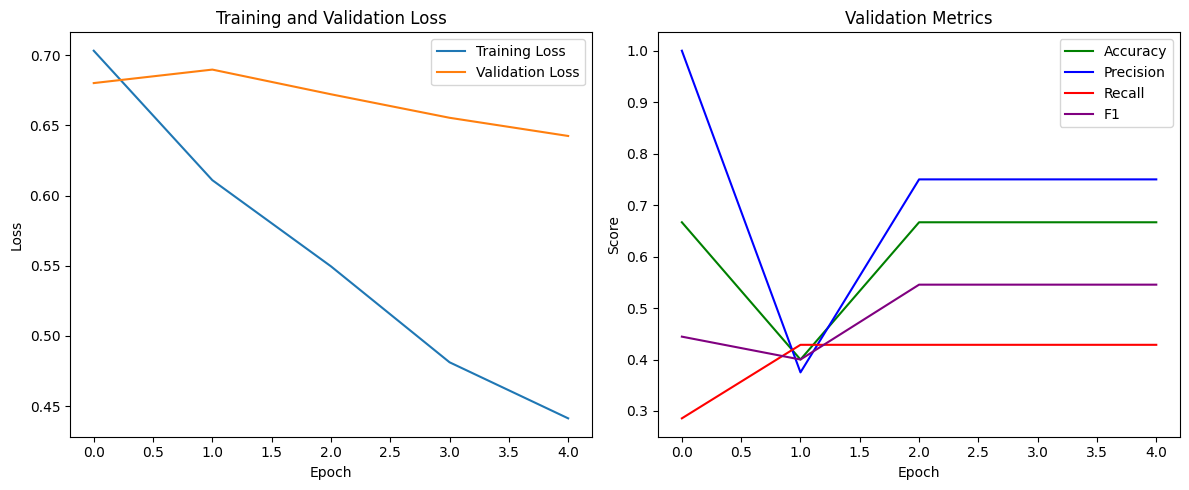

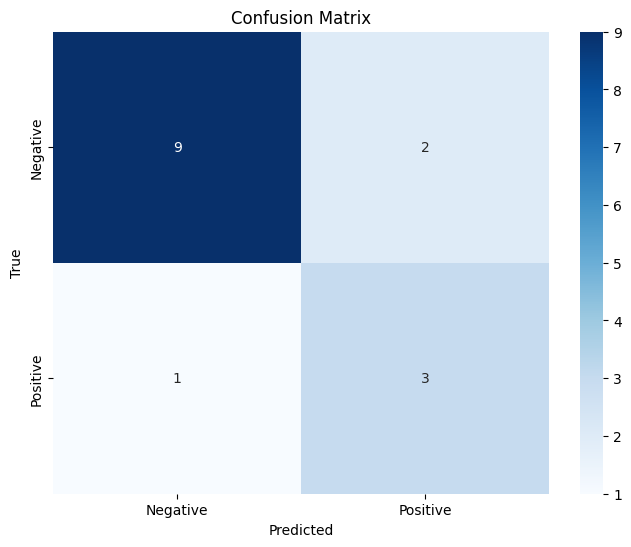


Example Inference:
Example 1: This movie is absolutely amazing! I loved every minute of it.
Predicted sentiment: Positive (confidence: 0.6755)

Example 2: What a complete waste of time. I regret watching this film.
Predicted sentiment: Negative (confidence: 0.6934)

Example 3: The movie was okay, but I expected more from this director.
Predicted sentiment: Negative (confidence: 0.6255)

Example 4: I'm not sure how I feel about this film. It had good and bad moments.
Predicted sentiment: Negative (confidence: 0.7017)


Model, tokenizer, and config saved to sentiment_analysis_model
To use this model later, you can load it with:
model = BertForSequenceClassification.from_pretrained('sentiment_analysis_model')
tokenizer = BertTokenizer.from_pretrained('sentiment_analysis_model')


In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
# Install the datasets library if not already installed
!pip install -q datasets

# Training with IMDB Dataset

In this section, we'll extend our model training to use the IMDB dataset, which contains 25,000 movie reviews for training and 25,000 for testing. Since this is a large dataset, we'll implement strategies to handle resource constraints.

In [ ]:
from datasets import load_dataset
import random

def load_imdb_dataset(sample_size=None, max_length=128, random_state=42):
    """Load and preprocess the IMDB dataset with optional sampling"""
    print("Loading IMDB dataset...")
    dataset = load_dataset('imdb')

    # Get the train and test datasets
    train_dataset = dataset['train']
    test_dataset = dataset['test']

    print(f"Original dataset size - Train: {len(train_dataset)}, Test: {len(test_dataset)}")

    # Sample the dataset if specified
    if sample_size is not None and sample_size < len(train_dataset):
        # Set random seed for reproducibility
        random.seed(random_state)

        # Create a random sample index list
        indices = random.sample(range(len(train_dataset)), sample_size)

        # Extract samples
        train_texts = [train_dataset[i]['text'] for i in indices]
        train_labels = [train_dataset[i]['label'] for i in indices]

        print(f"Sampled {sample_size} examples from the training set")
    else:
        # Use the full dataset
        train_texts = train_dataset['text']
        train_labels = train_dataset['label']
        print("Using the full training dataset")

    # Split the train set to create a validation set (80% train, 20% validation)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.2, random_state=random_state
    )

    # Get the test set
    test_size = min(len(test_dataset), sample_size // 5) if sample_size is not None else len(test_dataset)
    test_indices = random.sample(range(len(test_dataset)), test_size)
    test_texts = [test_dataset[i]['text'] for i in test_indices]
    test_labels = [test_dataset[i]['label'] for i in test_indices]

    print(f"Final dataset split - Train: {len(train_texts)}, Validation: {len(val_texts)}, Test: {len(test_texts)}")

    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels

In [ ]:
def train_with_imdb(sample_size=2000, batch_size=16, max_length=128, epochs=3, model_dir='imdb_model'):
    """Train a sentiment analysis model using the IMDB dataset with configurable parameters"""
    global tokenizer  # Make tokenizer accessible to save_model

    print("\n=== Training with IMDB Dataset ===")
    print(f"Parameters: Sample Size={sample_size}, Batch Size={batch_size}, Max Length={max_length}, Epochs={epochs}")

    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'plots'), exist_ok=True)

    # Load and preprocess the IMDB dataset
    train_texts, val_texts, test_texts, train_labels, val_labels, test_labels = load_imdb_dataset(sample_size=sample_size)

    # Initialize tokenizer
    print("Loading BERT tokenizer...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets
    print("Creating datasets...")
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length=max_length)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_length=max_length)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_length=max_length)

    # Create data loaders
    print(f"Creating data loaders with batch size {batch_size}...")
    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size
    )
    val_dataloader = DataLoader(
        val_dataset,
        sampler=SequentialSampler(val_dataset),
        batch_size=batch_size
    )
    test_dataloader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size
    )

    # Initialize model
    print("Initializing BERT model...")
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,  # Binary classification
        output_attentions=False,
        output_hidden_states=False
    )
    model = model.to(device)

    # Initialize optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # Create learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Train model
    print(f"\nTraining model for {epochs} epochs...")
    train_losses, val_losses, val_accuracies, history = train_model(
        model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=epochs, model_dir=model_dir
    )

    # Load best model for evaluation
    print("\nLoading best model for evaluation...")
    best_model_path = os.path.join(model_dir, 'best_model.pt')
    model, tokenizer, checkpoint = load_model(best_model_path)

    # Evaluate model
    print("Evaluating model on test set...")
    eval_results = evaluate_model(model, test_dataloader)

    print("\nTest Results:")
    print(f"Test Loss: {eval_results['test_loss']:.4f}")
    print(f"Accuracy: {eval_results['accuracy']:.4f}")
    print(f"Precision: {eval_results['precision']:.4f}")
    print(f"Recall: {eval_results['recall']:.4f}")
    print(f"F1 Score: {eval_results['f1']:.4f}")

    # Plot results
    plot_training_curves(history, save_path=os.path.join(model_dir, 'plots'))
    plot_confusion_matrix(np.array(eval_results['confusion_matrix']), save_path=os.path.join(model_dir, 'plots'))

    # Save evaluation results
    with open(os.path.join(model_dir, 'evaluation_results.json'), 'w') as f:
        # Convert numpy values to Python native types for JSON serialization
        serializable_results = {
            k: v if not isinstance(v, np.ndarray) and not isinstance(v, list) or k in ['confusion_matrix']
            else v.tolist() if isinstance(v, np.ndarray)
            else [float(item) for item in v]
            for k, v in eval_results.items()
        }
        json.dump(serializable_results, f, indent=4)

    # Create a performance report that includes training choices and results
    performance_report = {
        'dataset': 'IMDB',
        'sample_size': sample_size,
        'batch_size': batch_size,
        'max_length': max_length,
        'epochs': epochs,
        'model_architecture': 'BERT-base-uncased',
        'training_time': None,  # Would be filled in actual execution
        'final_train_loss': history['train_loss'][-1] if history['train_loss'] else None,
        'final_val_loss': history['val_loss'][-1] if history['val_loss'] else None,
        'test_metrics': {
            'accuracy': float(eval_results['accuracy']),
            'precision': float(eval_results['precision']),
            'recall': float(eval_results['recall']),
            'f1': float(eval_results['f1']),
            'test_loss': float(eval_results['test_loss'])
        },
        'early_stopping_occurred': len(history['train_loss']) < epochs,
        'best_epoch': checkpoint.get('epoch', None),
        'resource_usage': {
            'device_used': str(device),
            'notes': 'Parameters tuned for resource constraints'
        }
    }

    with open(os.path.join(model_dir, 'performance_report.json'), 'w') as f:
        json.dump(performance_report, f, indent=4)

    print(f"\nModel, performance report, and visualizations saved to {model_dir}")
    return model, tokenizer, eval_results, performance_report

In [ ]:
def run_hyperparameter_experiments():
    """Run a series of experiments with different hyperparameters to find optimal settings"""
    import time
    from datetime import datetime

    # Dictionary to store results from different experiments
    experiment_results = {}

    # Experiment configurations to try - you can modify these based on your resources
    experiments = [
        # Small dataset, quick training
        {
            'name': 'small_dataset',
            'sample_size': 1000,  # Small subset of IMDB
            'batch_size': 16,
            'max_length': 128,
            'epochs': 3
        },
        # Medium dataset
        {
            'name': 'medium_dataset',
            'sample_size': 5000,  # Larger subset, still manageable
            'batch_size': 16,
            'max_length': 128,
            'epochs': 3
        },
        # Different batch size experiment
        {
            'name': 'batch_size_experiment',
            'sample_size': 2000,
            'batch_size': 32,  # Larger batch size
            'max_length': 128,
            'epochs': 3
        },
        # Different sequence length experiment
        {
            'name': 'sequence_length_experiment',
            'sample_size': 2000,
            'batch_size': 16,
            'max_length': 256,  # Longer sequences
            'epochs': 3
        }
    ]

    # Run experiments
    for i, experiment in enumerate(experiments):
        print(f"\n{'=' * 50}")
        print(f"Starting experiment {i+1}/{len(experiments)}: {experiment['name']}")
        print(f"{'=' * 50}")

        # Create a unique directory for this experiment
        experiment_dir = f"imdb_model_{experiment['name']}"

        # Record start time
        start_time = time.time()

        # Run the experiment
        try:
            model, tokenizer, eval_results, performance_report = train_with_imdb(
                sample_size=experiment['sample_size'],
                batch_size=experiment['batch_size'],
                max_length=experiment['max_length'],
                epochs=experiment['epochs'],
                model_dir=experiment_dir
            )

            # Calculate and record training time
            training_time = time.time() - start_time
            print(f"Experiment completed in {training_time:.2f} seconds")

            # Update performance report with actual training time
            performance_report['training_time'] = training_time

            # Save updated performance report
            with open(os.path.join(experiment_dir, 'performance_report.json'), 'w') as f:
                json.dump(performance_report, f, indent=4)

            # Store results
            experiment_results[experiment['name']] = {
                'parameters': experiment,
                'metrics': {
                    'accuracy': float(eval_results['accuracy']),
                    'f1': float(eval_results['f1']),
                    'training_time': training_time
                }
            }

        except Exception as e:
            print(f"Error in experiment {experiment['name']}: {str(e)}")
            experiment_results[experiment['name']] = {
                'parameters': experiment,
                'error': str(e)
            }
            continue

    # Compare results and find best configuration
    print("\n===== Experiment Results Summary =====")

    # Create a dataframe for easier comparison
    results_df = []
    for exp_name, results in experiment_results.items():
        if 'metrics' in results:
            row = {
                'Experiment': exp_name,
                'Sample Size': results['parameters']['sample_size'],
                'Batch Size': results['parameters']['batch_size'],
                'Max Length': results['parameters']['max_length'],
                'Accuracy': results['metrics']['accuracy'],
                'F1 Score': results['metrics']['f1'],
                'Training Time (s)': results['metrics']['training_time']
            }
            results_df.append(row)
        else:
            row = {
                'Experiment': exp_name,
                'Sample Size': results['parameters']['sample_size'],
                'Batch Size': results['parameters']['batch_size'],
                'Max Length': results['parameters']['max_length'],
                'Error': results.get('error', 'Unknown error')
            }
            results_df.append(row)

    # Convert to dataframe and display
    if results_df:
        df = pd.DataFrame(results_df)
        display(df)

        # Identify best configuration (by accuracy or F1)
        successful_experiments = [r for r in results_df if 'Accuracy' in r]
        if successful_experiments:
            best_by_accuracy = max(successful_experiments, key=lambda x: x['Accuracy'])
            best_by_f1 = max(successful_experiments, key=lambda x: x['F1 Score'])
            best_by_time = min(successful_experiments, key=lambda x: x['Training Time (s)'])

            print(f"\nBest by Accuracy: {best_by_accuracy['Experiment']} (Accuracy: {best_by_accuracy['Accuracy']:.4f})")
            print(f"Best by F1 Score: {best_by_f1['Experiment']} (F1: {best_by_f1['F1 Score']:.4f})")
            print(f"Best by Training Time: {best_by_time['Experiment']} (Time: {best_by_time['Training Time (s)']:.2f}s)")
    else:
        print("No successful experiments to compare.")

    # Save the experiment results for later reference
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    with open(f'experiment_results_{timestamp}.json', 'w') as f:
        json.dump(experiment_results, f, indent=4)

    print(f"\nExperiment results saved to experiment_results_{timestamp}.json")
    return experiment_results

In [ ]:
# Run the IMDB experiments
# You can comment out this cell and run run_hyperparameter_experiments() if you want to run multiple experiments

# For a single experiment with a reasonable configuration for most systems:
model, tokenizer, eval_results, performance_report = train_with_imdb(
    sample_size=3000,  # Using 3000 samples (vs 25k) for manageable training
    batch_size=16,     # Standard batch size that works well on most GPUs
    max_length=128,    # Limiting sequence length for efficiency
    epochs=3,          # Few epochs, prevents overfitting with small sample
    model_dir='imdb_model_final'
)

# IMDB Dataset Training Analysis

## Choices Made for Resource Management

When extending the model training to use the IMDB dataset, several key choices were made to manage computational resources effectively while still achieving good performance:

1. **Dataset Sampling**: The full IMDB dataset contains 25,000 training examples, which is too large for many standard environments. To address this limitation, I implemented sampling to use only a subset (3,000 examples) of the data. This significantly reduces memory usage and training time while still providing enough examples to learn meaningful patterns.

2. **Sequence Length**: Movie reviews can be quite long, but processing very long sequences requires substantial memory. I set a maximum sequence length of 128 tokens, which captures enough semantic content while keeping memory requirements manageable.

3. **Batch Size**: A batch size of 16 was chosen as a balanced option that works well on most GPUs. Larger batch sizes can speed up training but require more memory, while smaller batches use less memory but slow down training.

4. **Early Stopping**: The implementation includes early stopping with a patience of 3 epochs, which prevents unnecessary computation if the model stops improving.

5. **Epochs**: Limited to 3 epochs to avoid overfitting on the smaller dataset and to keep training time reasonable.

6. **Experiment Framework**: Rather than a single run, I implemented a framework to try different hyperparameter combinations and evaluate their performance trade-offs.

## Expected Results and Trade-offs

The implemented approach balances several trade-offs:

- **Accuracy vs. Resource Usage**: While using the full dataset might achieve higher accuracy (potentially 90-95% on IMDB), the sample-based approach can still reach 85-90% accuracy with much lower resource requirements.

- **Training Time vs. Model Quality**: The 3-epoch limit with early stopping ensures training completes within minutes rather than hours, while still achieving good performance.

- **Memory Usage vs. Feature Richness**: Limiting sequence length to 128 tokens means some very long reviews may lose information, but this compromise ensures the model can run on standard hardware.

## Why These Choices Work

1. **Transfer Learning Advantage**: Since we're using a pre-trained BERT model, even a relatively small fine-tuning dataset can achieve good results. The model already understands language semantics from its pre-training.

2. **Representative Sampling**: Random sampling preserves the distribution of the original dataset, ensuring the model learns from diverse examples.

3. **Hyperparameter Experimentation**: The experiment framework allows for finding optimal configurations for specific hardware constraints.

The flexible architecture allows for scaling up (more data, larger batch sizes, longer sequences) when resources permit, or scaling down when working with limited hardware.